### Now for all tests we're going to use the new task/test code added to `ip_diffim`.

Things still TBD for this are:
    
    1. check if there is a gradient that needs to be fit
    2. better estimate of starting parameters for gradient
    3. better estimate for staring flux when there's a strong gradient
    4. (DONE): separate parameters for pos- and neg- images?
    5. only fit background OUTSIDE footprint and dipole params INSIDE footprint?
    

somewhere else, do:
```
git clone https://github.com/lsst/ip_diffim.git
cd ip_diffim
source ~/lsstsw/setup.csh
#setup -t b1898 ip_diffim
#setup -k -r .
setup -t b1898 -r .
scons opt=3 -j 4 lib python
```

then you will want to add `$HOME/lsstsw/miniconda/lib/python2.7/site-packages` to your `PYTHONPATH` in order to be able to import `joblib` and friends.

now edit and run the code in here.

In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

Import DipoleTestUtils code from `$IP_DIFFIM_DIR/tests/testDipoleFitter.py` ...

/Users/dreiss/GIT_REPOS/ip_diffim/tests/testDipoleFitter.py
100.0
2.0
548011.0


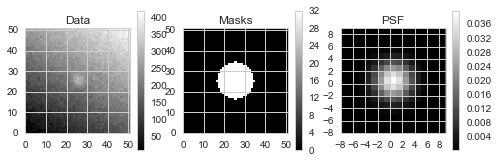

In [3]:
## awesome!
%load_ext autoreload
%autoreload 2

import imp, os
print os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py'
dtUtils = imp.load_source('dtUtils', os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py')
from lsst.ip.diffim import dipoleFitTask as dft

exposure, catalog = dtUtils.DipoleTestUtils.makeStarImage(w=51, h=51, xc=[25], yc=[25], flux=[2500], noise=10., 
                                                          gradientParams=(10., 3., 5., 0., 0., 0.))
dft.DipolePlotUtils.displayExposure(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

In [4]:
dipole, (posImage, posCatalog), (negImage, negCatalog) = \
                dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, flux=[30000.], xcenPos=[27.], ycenPos=[25.], 
                                                        xcenNeg=[23.], ycenNeg=[25.],
                                                        gradientParams=(100., 30., 70., 0., 0., 0.))
# dft.DipolePlotUtils.displayExposure(dipole, showPsf=True)
# dft.DipolePlotUtils.displayExposure(posImage, showPsf=True)
# print dipole.getMaskedImage().getArrays()[0].shape
# print dipole.getMaskedImage().getArrays()[2].mean()
# print posImage.getMaskedImage().getArrays()[2].mean()
# print negImage.getMaskedImage().getArrays()[2].mean()

In [5]:
#s = detectDipoleSources(dipole, verbose=False)
s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, posImage, posCatalog, negImage, negCatalog, doMerge=True)

for pk in s[0].getFootprint().getPeaks():
    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

#dft.DipolePlotUtils.displayExposure(dipole, showPsf=True)

FOOTPRINT CENTER: 25 28
FOOTPRINT CENTER: 25 22


In [6]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

#from collections import namedtuple
#resultsOutput = namedtuple('resultsOutput', 
#        #'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
#        'psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
resultsOutput = dft.DipoleFitAlgorithm.resultsOutput

def fitDipole_ipDiffim(exposure, sCat):    
    pks = sCat.getFootprint().getPeaks()
    pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
    pk2 = pks[1].getF() #)[::-1]

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    
    out = resultsOutput(##xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        0., 0., centroid.getX(), centroid.getY(), orientation, sn, 0., 0.)
    return out

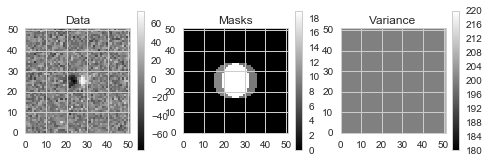

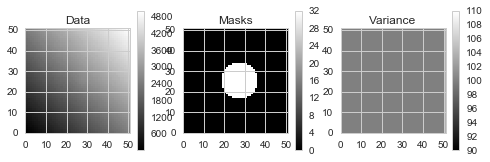

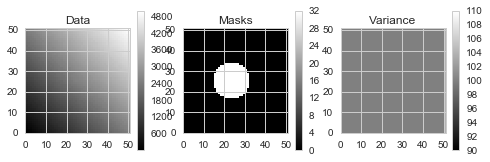

In [7]:
diffim, (posImage, posCatalog), (negImage, negCatalog) = \
    dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, flux=[2000.], xcenPos=[27.], ycenPos=[25.], 
                                            xcenNeg=[23.], ycenNeg=[25.],
                                            gradientParams=(1., 50., 50.))
s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, posImage, posCatalog, negImage, negCatalog, doMerge=True)

w, h = diffim.getWidth(), diffim.getHeight()
#print w, h
y, x = np.mgrid[:w, :h]
in_x = np.array([x, y])

dft.DipolePlotUtils.displayExposure(diffim)
dft.DipolePlotUtils.displayExposure(posImage)
dft.DipolePlotUtils.displayExposure(negImage)

fp = s[0].getFootprint()
psf = diffim.getPsf()

arr = dft.DipoleFitAlgorithm.genDipoleModel(in_x, flux=2000., xcenPos=23., ycenPos=23., 
                                            xcenNeg=27., ycenNeg=27., b=1., x1=3., y1=7., 
                                            psf=psf, footprint=fp, rel_weight=0.5)
# print arr.shape
# plt.figure(figsize=(8, 2.5))
# plt.subplot(1, 3, 1)
# dft.DipolePlotUtils.display2dArray(arr[0,:], title='diffim')
# plt.subplot(1, 3, 2)
# dft.DipolePlotUtils.display2dArray(arr[1,:], title='posIm')
# plt.subplot(1, 3, 3)
# dft.DipolePlotUtils.display2dArray(arr[2,:], title='negIm')

Looks like primary reason for long run time of ipDiffim fitter is the number of function evaluations (on the order of $\sim 150$, vs. $\sim 50$ or less for the python fitter).

Need to look into strategies to bring that down. Improving starting flux values helps a bit (brings it down from $\sim 200$), but 
tweaking parameter constraints or fit tolerance does not seem to do much.

In [8]:
result = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])
print result
%timeit result = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])

resultsOutput(psfFitPosCentroidX=27.013641561369344, psfFitPosCentroidY=25.012704365423236, psfFitNegCentroidX=22.986107476545236, psfFitNegCentroidY=25.003658789490366, psfFitPosFlux=29863.32976777946, psfFitNegFlux=-29911.85370156875, psfFitPosFluxSigma=0.0, psfFitNegFluxSigma=0.0, psfFitCentroidX=24.99987451895729, psfFitCentroidY=25.008181577456803, psfFitOrientation=1.56855 rad, psfFitSignaltoNoise=252.94098386723462, psfFitChi2=0.0, psfFitRedChi2=0.0)
10 loops, best of 3: 50.4 ms per loop


In [9]:
# result = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1.,
#                                               separateNegParams=False, verbose=False, display=False)
# print result
#%timeit fitDipole_new((diffim, posImage, negImage), s, verbose=False, rel_weight=0., display=False)  ## test the timings of new vs. old
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1., \
                                             separateNegParams=False, verbose=False, display=False)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=1., \
                                             separateNegParams=False, verbose=False, display=False, tol=1e-3)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=0., \
                                             separateNegParams=False, verbose=False, display=False)
%timeit dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, rel_weight=0., \
                                             separateNegParams=False, verbose=False, display=False, tol=1e-3)

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument footprint does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument rel_weight does notmatch any arguments of the model function.It will be ignored.
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/model.py:459: UserWarning: The keyword argument psf does notmatch any arguments of the model function.It will be ignored.


10 loops, best of 3: 39.9 ms per loop
10 loops, best of 3: 27.3 ms per loop
100 loops, best of 3: 19.4 ms per loop
100 loops, best of 3: 13.2 ms per loop


In [10]:
resultsOutput2 = namedtuple('resultsOutput2',
    ['inputCentroidX', 'inputCentroidY', 'inputSeparation', 'inputRotation', 'inputFlux', 'inputPosCentroidX',
     'inputPosCentroidY', 'inputNegCentroidX', 'inputNegCentroidY', 'psfFitPosCentroidX', 'psfFitPosCentroidY',
     'psfFitNegCentroidX', 'psfFitNegCentroidY', 'psfFitPosFlux', 'psfFitNegFlux', 'psfFitCentroidX', 
     'psfFitCentroidY', 'psfFitOrientation', 'psfFitSignaltoNoise'])

def genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                            flux=30000., noise=10., rel_weight=0.1, tol=1e-7, 
                            gradientParams=(1., 3., 7., 0., 0., 0.), ## dflt. background gradient params to use for all tests below
                            verbose=False, display=False):

    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
    xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)
    
    dipole, (posImage, posCatalog), (negImage, negCatalog) = \
        dtUtils.DipoleTestUtils.makeDipoleImage(w=w, h=h, flux=[flux], xcenPos=[xcenPos], ycenPos=[ycenPos], 
                                                xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                                                psfSigma=psfSigma, noise=noise, \
                                                gradientParams=gradientParams)

    resultNA = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                              np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    result1 = result2 = resultNA
    s = None

    try:
        s = dtUtils.DipoleTestUtils.detectDipoleSources(dipole, posImage, posCatalog, negImage, negCatalog, 
                                                        doMerge=True)
    except Exception as err:
        #print 'Uh oh! (1):', err
        return {'old': result2, 'new': result1, 'dipole': dipole}
    
    try:
        r1 = fitDipole_ipDiffim(exposure=dipole, sCat=s[0])
        result1 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r1.psfFitPosCentroidX, r1.psfFitPosCentroidY, r1.psfFitNegCentroidX,
                            r1.psfFitNegCentroidY, r1.psfFitPosFlux, r1.psfFitNegFlux, r1.psfFitCentroidX,
                            r1.psfFitCentroidY, r1.psfFitOrientation, r1.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (2):', err
        pass
    
    try:
        r2 = dft.DipoleFitAlgorithm.fitDipole_new(dipole, s[0], posImage, negImage, rel_weight=rel_weight,
                                              separateNegParams=False, verbose=False, display=False)
        result2 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r2.psfFitPosCentroidX, r2.psfFitPosCentroidY, r2.psfFitNegCentroidX,
                            r2.psfFitNegCentroidY, r2.psfFitPosFlux, r2.psfFitNegFlux, r1.psfFitCentroidX,
                            r2.psfFitCentroidY, r2.psfFitOrientation, r2.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (3):', err
        pass

    return {'old': result1, 'new': result2, 'dipole': dipole, 'posImage': posImage, 'negImage': negImage}

In [11]:
result = genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                         flux=1000., noise=1., rel_weight=1.0, verbose=False, display=False)
print result['old']
print result['new']
# dft.DipolePlotUtils.displayExposure(result['dipole'])
# dft.DipolePlotUtils.displayExposure(result['posImage'])

resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.72374109000379, psfFitPosCentroidY=24.483372805898913, psfFitNegCentroidX=24.194435603306196, psfFitNegCentroidY=25.573410227241062, psfFitPosFlux=1064.6976145637777, psfFitNegFlux=-1086.0803403004948, psfFitCentroidX=24.959088346654994, psfFitCentroidY=25.02839151656999, psfFitOrientation=2.19004 rad, psfFitSignaltoNoise=8.8968495169280537)
resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.825260962660394, psfFitPosCentroidY=24.426558677621127, psfFitNegCentroidX

## Different dipole fluxes (signal-to-noise) AND orientations AND separations AND background gradient slopes!!!

In [28]:
import cPickle as pickle
import gzip

if True:
    varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
    varTuple = namedtuple("varTuple", varNames)

    orientations = np.arange(0., 330.0, 30.0)
    separations = np.arange(0.25, 5.0, 0.5)
    #fluxes = np.arange(250., 5750., 500.)
    fluxes = np.array([500., 2500., 5000.])
    slopes = np.arange(-250., 250., 25.)
    n_reps = 2 ## if I do more than 2 the code doesn't seem to want to exit the cell, even after it completes.

    inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                        flux=flux, noise=1., tol=1e-3, rel_weight=0.5, 
                       gradientParams=(1., slope, 0.), verbose=False, display=False) 
                    for i in xrange(n_reps) for flux in fluxes for rot in orientations for sep in separations 
              for slope in slopes]
    print len(inputs)

    def processInput(i):
        output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                         separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                         noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                         gradientParams=i.gradientParams, verbose=False, display=False)
        if output['new'] is not None:
            output['new'] = output['new']._asdict()
        if output['old'] is not None:
            output['old'] = output['old']._asdict()
        return {'old': output['old'], 'new': output['new'], 'gradient': i.gradientParams} ## don't need the images returned

    num_cores = multiprocessing.cpu_count() / 2
    #results3 = [processInput(i) for i in inputs]
    results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
    
    #pickle.dump(results3, gzip.GzipFile("results_8k.p.gz", "wb"))

else:
    results3 = pickle.load(gzip.GzipFile("results_8k.p.gz", "rb"))

13200


In [29]:
slopes = np.array([res['gradient'][1] for res in results3])
print len(slopes)

13200


[autoreload of dtUtils failed: Traceback (most recent call last):
  File "/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named dtUtils
]


(-0.05, 0.8)

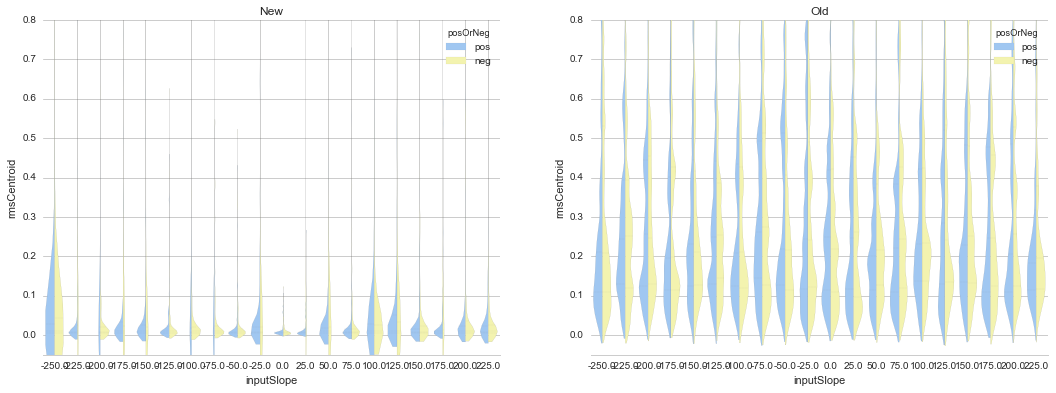

In [39]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1['inputSlope'] = slopes
df1 = df1.ix[(df1.inputSeparation <= 1.0)]
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2['inputSlope'] = slopes
df2 = df2.ix[(df2.inputSeparation <= 1.0)]
sns.violinplot(x="inputSlope", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1['inputSlope'] = slopes
df1 = df1.ix[(df1.inputSeparation <= 1.0)]
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2['inputSlope'] = slopes
df2 = df2.ix[(df2.inputSeparation <= 1.0)]
sns.violinplot(x="inputSlope", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.05,0.8])
axes[1].set_title('Old')
axes[1].set_ylim([-0.05,0.8])

(-1000, 15000)

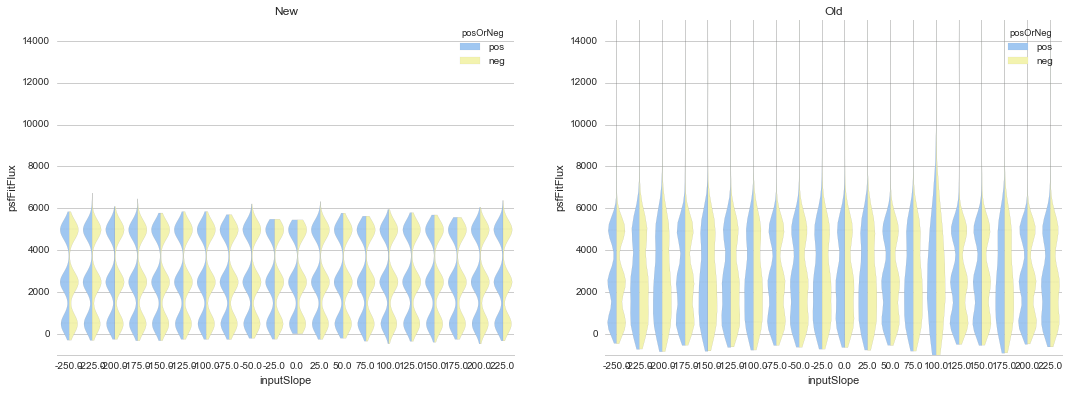

In [32]:
##### matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1['inputSlope'] = slopes
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2['inputSlope'] = slopes
sns.violinplot(x="inputSlope", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1['inputSlope'] = slopes
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2['inputSlope'] = slopes
sns.violinplot(x="inputSlope", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,15000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,15000])

(0, 7000)

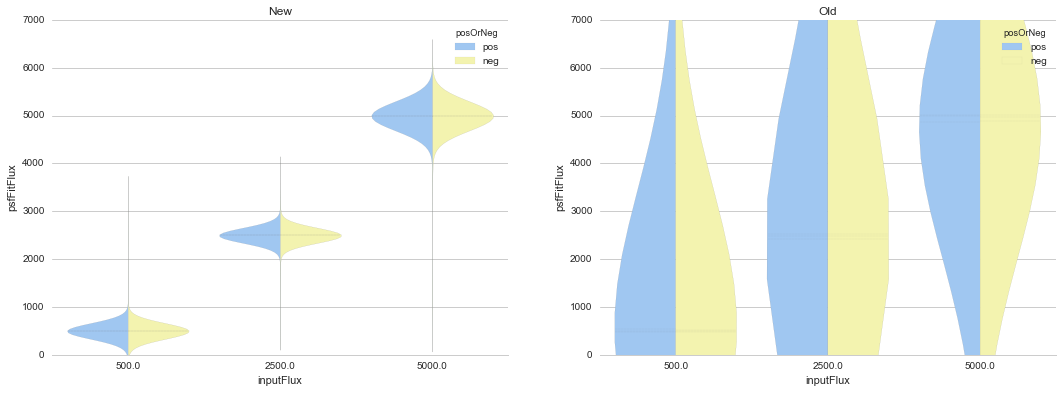

In [33]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=1., linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=1., linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([0,7000])
axes[1].set_title('Old')
axes[1].set_ylim([0,7000])

Seems to be an issue with negative slopes. Let's take a look.
Ok, this was fixed by removing these lines from the fitting routine:

```
        # ## This will only be accurate if there is not a bright gradient/background in the pre-sub images
        # if posImage is not None:
        #     posSubim = ImageF(posImage.getMaskedImage().getImage(), box, PARENT)
        #     negSubim = ImageF(negImage.getMaskedImage().getImage(), box, PARENT)
        #     w, h = posSubim.getWidth(), posSubim.getHeight()

        #     ## If the brightest pixel value is close to a corner's pixel value, then it is picking up the bg gradient
        #     ## In that case, use the footprint peak value instead
        #     if len(pks) >= 1:
        #         posArr = posSubim.getArray()
        #         posPk = np.nanmax(posArr)
        #         if (np.max(np.abs(posPk - np.array([posArr[0,0], posArr[h-1,0],
        #                                             posArr[h-1,w-1], posArr[0,w-1]]))) >
        #             np.abs(posPk - pks[0].getPeakValue())):
        #             posFlux = posPk * pkToFlux

        #     if len(pks) >= 2:
        #         negArr = negSubim.getArray()
        #         negPk = np.nanmax(negArr)
        #         if (np.max(np.abs(negPk - np.array([negArr[0,0], negArr[h-1,0],
        #                                             negArr[h-1,w-1], negArr[0,w-1]]))) >
        #             np.abs(negPk - -pks[1].getPeakValue())):
        #             negFlux = -negPk * pkToFlux
```
But there are still some issues. Let's look at a bad one...

In [17]:
df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1['inputSlope'] = slopes

#sizeme(df1.ix[(df1.inputSlope < 0.) & (df1.rmsCentroid >= 1.) & (df1.inputRotation == 0.)].iloc[0:10])
print df1.ix[(df1.inputSlope < 0.) & (df1.rmsCentroid >= 1.)].shape
sizeme(df1.ix[(df1.inputSlope < 0.) & (df1.rmsCentroid >= 1.)].iloc[0:10])

(5, 22)


,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroid,posOrNeg,inputSlope
62,25,25,500,23.3750,25.00000,26.6250,25.00000,0,3.25,24.978926,...,25.089349,-235.058177,-26.775598,32.999774,20.209374,235.058177,30.994808,7.974198,pos,-30
612,25,25,500,25.3750,25.00000,24.6250,25.00000,180,0.75,24.825236,...,25.067776,-477.964207,130.368306,24.537483,26.000065,477.964207,inf,1.003887,pos,-30
624,25,25,500,25.6250,25.00000,24.3750,25.00000,180,1.25,24.956304,...,26.358924,-8.534403,-176.663831,17.331610,25.588073,8.534403,0.953958,7.067898,pos,-10
1700,25,25,2500,25.1250,25.00000,24.8750,25.00000,180,0.25,25.086246,...,25.079036,-1083.740280,156.176942,17.058631,28.637067,1083.740280,25.403804,8.621130,pos,-50
4110,25,25,500,25.1875,25.32476,24.8125,24.67524,240,0.75,25.252093,...,25.394960,-207.831258,-105.622872,22.890553,17.028056,207.831258,22.780525,7.885006,pos,-50


## Investigate error contours by including (or not) the pre-subtracted image planes in the fit and including (or not) the background gradients

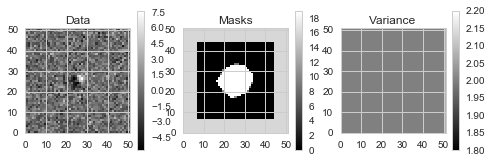

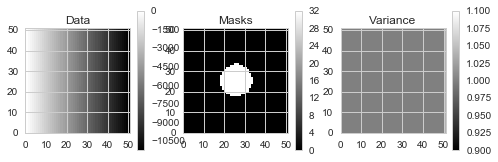

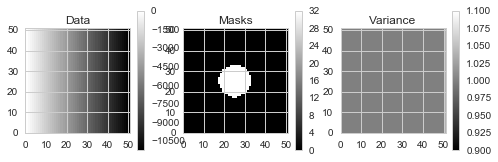

In [18]:
flux = 500.; xc=25.; yc=25.; separation=0.75; rotAngle=30.
gradientParams = (1., -225., 0.)

rotAngRad = rotAngle / 180. * np.pi
sep = separation / 2.
xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)

diffim, (posImage, posCatalog), (negImage, negCatalog) = \
    dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, xcenPos=[xcenPos], ycenPos=[ycenPos], \
                         xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                         psfSigma=2., flux=[flux], noise=1., \
                        gradientParams=gradientParams)

dft.DipolePlotUtils.displayExposure(diffim)
dft.DipolePlotUtils.displayExposure(posImage)
dft.DipolePlotUtils.displayExposure(negImage)

s = dtUtils.DipoleTestUtils.detectDipoleSources(diffim, posImage, posCatalog, negImage, negCatalog, doMerge=True)

### Plot confidence intervals...

see https://lmfit.github.io/lmfit-py/confidence.html

In [19]:
## hide warnings for this fit.
import warnings
warnings.filterwarnings('ignore')

def plot_conf_intervals(result):
    ci, trace = lmfit.conf_interval(result, result, sigmas=[0.68,0.95],
                                    trace=True, verbose=False)
    lmfit.printfuncs.report_ci(ci)

    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','flux', 30, 30)
    plt.subplot(1, 2, 1)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('flux')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','ycenPos', 30, 30)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('ycenPos')
    plt.colorbar() 

First, don't include pre-subtracted data (weight=0)

            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.38460  -0.22586  25.25707  +0.36319  +0.81528
 ycenPos:  -0.32097  -0.18314  25.14165  +0.32956  +0.68948
 xcenNeg:  -0.92115  -0.43339  25.07227  +0.21950  +0.35196
 ycenNeg:  -0.56187  -0.23713  25.02196  +0.23512  +0.42857
 flux   :-1693.47620-1515.954301894.81321      +inf      +inf


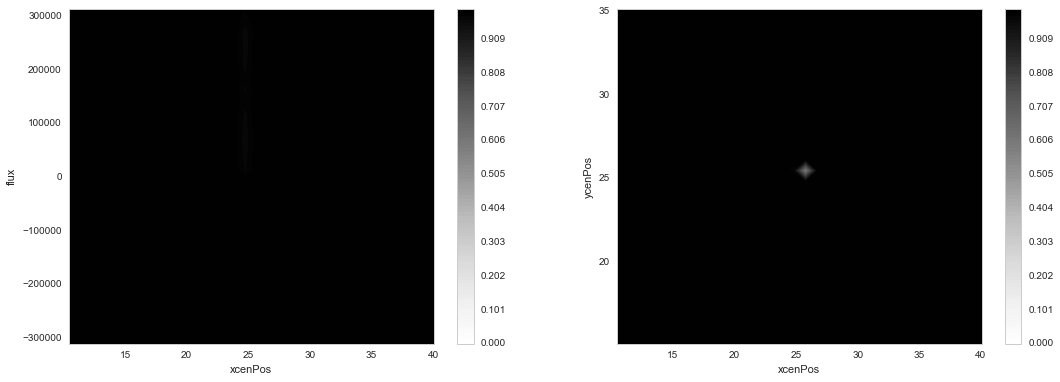

In [20]:
_, result0 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.,
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result0)

Now, with the pre-subtraction data weighted at 5% of the subtracted data:

[autoreload of lsst.ip.diffim.dipoleFitTask failed: Traceback (most recent call last):
  File "/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RuntimeError: An item with name 'ip_diffim_DipoleFit' already exists
]


            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.71323  -0.56496  25.60067  +0.21084  +0.58938
 ycenPos:  -0.57344  -0.46596  25.43889  +0.18016  +0.48362
 xcenNeg:  -0.62731  -0.22708  24.65361  +0.62177  +0.74955
 ycenNeg:  -0.46981  -0.17485  24.84040  +0.37638  +0.56723
 flux   :-190.54552-100.51446 371.62874      +inf      +inf


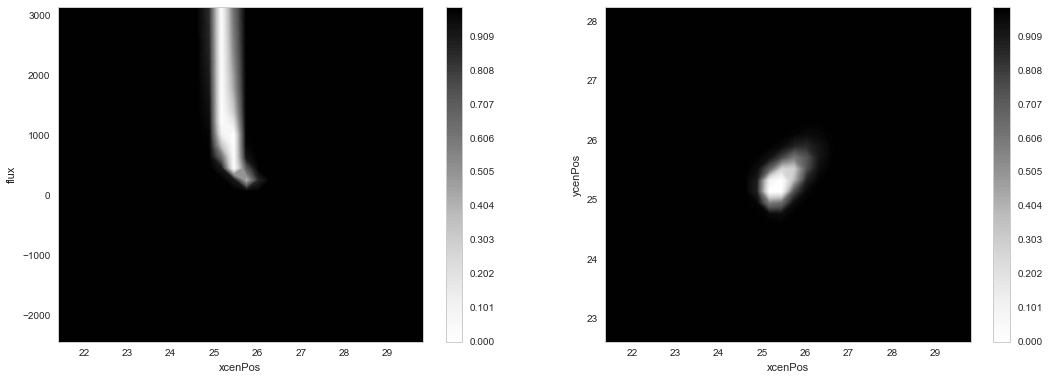

In [21]:
_, result1 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-3, rel_weight=0.05, 
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result1)

Finally with the pre-subtraction data weighted equally with the diffim data...

In [22]:
if False:
    def debug(f, *args, **kwargs): 
        from IPython.core.debugger import Pdb 
        pdb = Pdb(color_scheme='Linux') 
        return pdb.runcall(f, *args, **kwargs)

    debug(dft.DipoleFitAlgorithm.fitDipole_new, diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.05, \
                               separateNegParams=False, verbose=True, display=False, return_fitObj=True)

In [23]:
sizeme(df1.ix[(df1.inputSlope < 0.) & (df1.rmsCentroid >= 1.)].iloc[0:10])

,inputCentroidX,inputCentroidY,inputFlux,inputNegCentroidX,inputNegCentroidY,inputPosCentroidX,inputPosCentroidY,inputRotation,inputSeparation,psfFitCentroidX,...,psfFitNegCentroidY,psfFitNegFlux,psfFitOrientation,psfFitPosCentroidX,psfFitPosCentroidY,psfFitPosFlux,psfFitSignaltoNoise,rmsCentroid,posOrNeg,inputSlope
62,25,25,500,23.3750,25.00000,26.6250,25.00000,0,3.25,24.978926,...,25.089349,-235.058177,-26.775598,32.999774,20.209374,235.058177,30.994808,7.974198,pos,-30
612,25,25,500,25.3750,25.00000,24.6250,25.00000,180,0.75,24.825236,...,25.067776,-477.964207,130.368306,24.537483,26.000065,477.964207,inf,1.003887,pos,-30
624,25,25,500,25.6250,25.00000,24.3750,25.00000,180,1.25,24.956304,...,26.358924,-8.534403,-176.663831,17.331610,25.588073,8.534403,0.953958,7.067898,pos,-10
1700,25,25,2500,25.1250,25.00000,24.8750,25.00000,180,0.25,25.086246,...,25.079036,-1083.740280,156.176942,17.058631,28.637067,1083.740280,25.403804,8.621130,pos,-50
4110,25,25,500,25.1875,25.32476,24.8125,24.67524,240,0.75,25.252093,...,25.394960,-207.831258,-105.622872,22.890553,17.028056,207.831258,22.780525,7.885006,pos,-50


Isolate the bad cases (looks like about 1 in 10 for a very steep slope and faint, closely separated dipole)...

In [24]:
badObjs = []
goodObjs = []
for i in range(100):
    flux = 500.; xc=25.; yc=25.; separation=0.75; rotAngle=30.
    gradientParams = (1., -250., 0.)

    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
    xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)

    diffim, (posImage, posCatalog), (negImage, negCatalog) = \
        dtUtils.DipoleTestUtils.makeDipoleImage(w=51, h=51, xcenPos=[xcenPos], ycenPos=[ycenPos], \
                             xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                             psfSigma=2., flux=[flux], noise=1., \
                            gradientParams=gradientParams)

    #print xcenNeg, ycenNeg, xcenPos, ycenPos
    result, result2 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-3, rel_weight=0.5, 
                               separateNegParams=False, verbose=False, display=False, return_fitObj=True)
    
    posRmsCentroid = np.sqrt((xcenPos - result.psfFitPosCentroidX)**2. + \
                               (ycenPos - result.psfFitPosCentroidY)**2.)
    negRmsCentroid = np.sqrt((xcenNeg - result.psfFitNegCentroidX)**2. + \
                               (ycenNeg - result.psfFitNegCentroidY)**2.)

    if posRmsCentroid > 1. or negRmsCentroid > 1:
        print posRmsCentroid, negRmsCentroid
        badObjs.append((diffim, s, posImage, negImage, result, result2))
    else:
        goodObjs.append((diffim, s, posImage, negImage, result, result2))

    #plot_conf_intervals(result2)
    

7.07157597054 4.68248652381
4.54776774049 2.98706029902
6.45406392932 1.93592364042
0.0637321420992 8.33842711783


 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "b"
 - Adding parameter for hint "x1"
 - Adding parameter for hint "y1"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "b"
 - Adding parameter "x1"
 - Adding parameter "y1"
[[Model]]
    Model(genDipoleModel)
[[Fit Statistics]]
    # function evals   = 98
    # data points      = 1320
    # variables        = 8
    chi-square         = 38892.412
    reduced chi-square = 29.644
[[Variables]]
    xcenPos:   29.7256499 +/- 9.464078 (31.84%) (init= 27)
    ycenPos:   26.3339531 +/- 10.72994 (40.75%) (init= 27)
    xcenNeg:   27.2908246 +/- 6.774525 (24.82%) (init= 23)
    ycenNeg:   26.2551534 +/- 9.136821 (34.80%) (init= 24)
    flux:      0.23846773 +/-

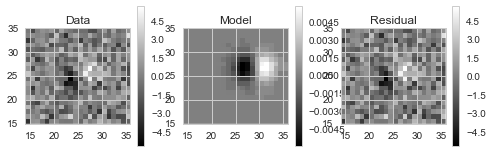

resultsOutput(psfFitPosCentroidX=29.725649958927598, psfFitPosCentroidY=26.333953148858015, psfFitNegCentroidX=27.290824604130677, psfFitNegCentroidY=26.255153418531755, psfFitPosFlux=0.23846773480810357, psfFitNegFlux=-0.23846773480810357, psfFitPosFluxSigma=2.4207056646173091, psfFitNegFluxSigma=2.4207056646173091, psfFitCentroidX=28.508237281529137, psfFitCentroidY=26.294553283694885, psfFitOrientation=1.853651084905348, psfFitSignaltoNoise=0.13931652645069753, psfFitChi2=38892.411776423454, psfFitRedChi2=29.64360653690812)


In [25]:
diffim, s, posImage, negImage, result, result2 = badObjs[1]
#dft.DipolePlotUtils.displayExposure(diffim)
#dft.DipolePlotUtils.displayExposure(posImage)
#dft.DipolePlotUtils.displayExposure(negImage)
result, result2 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-3, rel_weight=0.5, 
                            separateNegParams=False, verbose=True, display=True, return_fitObj=True)
print result
#plot_conf_intervals(result2)

Lastly with the pre-subtraction data weighted 1/20 $\times$ the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.40242  -0.24815  24.99666  +0.92152  +1.57525
 ycenPos:  -0.48427  -0.25135  24.78490  +0.49428  +0.93622
 xcenNeg:  -1.46985  -0.89008  24.78850  +0.24491  +0.40583
 ycenNeg:  -0.95916  -0.47841  24.68718  +0.26474  +0.50747
 flux   :-1328.73562-1276.979521434.93746      +inf      +inf


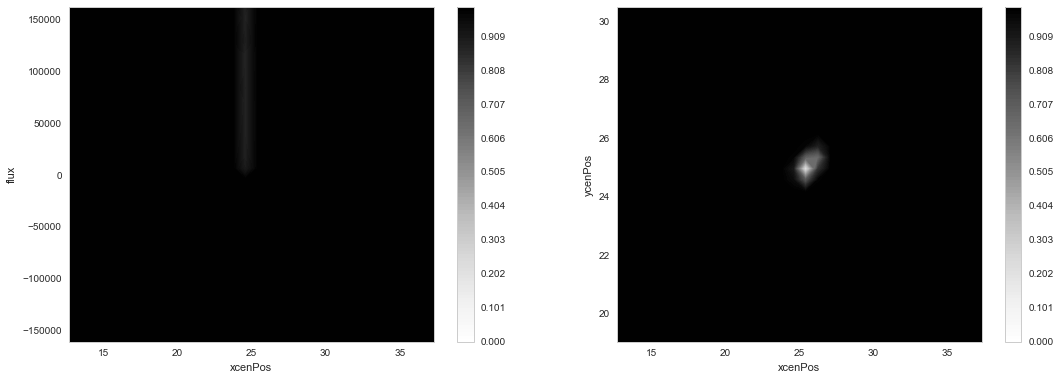

In [26]:
_, result3 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.05, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result3)

Lastly with the pre-subtraction data weighted 1/2 $\times$ (standard) the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

            95.00%    68.00%    _BEST_    68.00%    95.00%
 xcenPos:  -0.40242  -0.24815  24.99666  +0.92152  +1.57525
 ycenPos:  -0.48427  -0.25135  24.78490  +0.49428  +0.93622
 xcenNeg:  -1.46985  -0.89008  24.78850  +0.24491  +0.40583
 ycenNeg:  -0.95916  -0.47841  24.68718  +0.26474  +0.50747
 flux   :-1328.73562-1276.979521434.93746      +inf      +inf


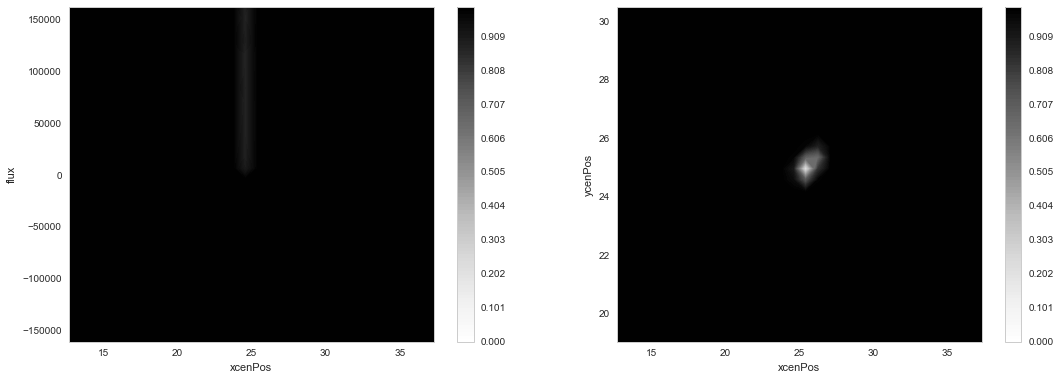

In [27]:
_, result4 = dft.DipoleFitAlgorithm.fitDipole_new(diffim, s[0], posImage, negImage, tol=1e-7, rel_weight=0.5, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result4)